In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import zipfile
import os
from collections import Counter
from google.colab import files
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Set seed for reproducible results
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:

print("*" * 70)
print("STEP 1: DATASET UPLOAD")
print("*" * 70)
print("Upload your dataset archive (zip format)")

# File upload interface
uploaded_files = files.upload()
archive_name = list(uploaded_files.keys())[0]
print(f"[INFO] File received: {archive_name}")

# Extract archive contents
destination = "dataset"
print(f"[INFO] Extracting to '{destination}' directory...")
with zipfile.ZipFile(archive_name, 'r') as archive:
    archive.extractall(destination)
print("[SUCCESS] Extraction completed\n")

**********************************************************************
STEP 1: DATASET UPLOAD
**********************************************************************
Upload your dataset archive (zip format)


Saving animal_dataset.zip to animal_dataset.zip
[INFO] File received: animal_dataset.zip
[INFO] Extracting to 'dataset' directory...
[SUCCESS] Extraction completed



[INFO] Dataset location: dataset/animal_dataset
[INFO] Directory contents: ['panda', 'dog', 'cat']

**********************************************************************
STEP 2: DATA PREPROCESSING
**********************************************************************
Target image size: 32x32 (grayscale)
Detected categories: ['cat', 'dog', 'panda']

Processing cat: 100 images
Processing dog: 100 images
Processing panda: 100 images

**********************************************************************
DATASET INFORMATION
**********************************************************************
Total samples: 300
Categories: ['cat', 'dog', 'panda']
Class distribution: Counter({np.int32(0): 100, np.int32(1): 100, np.int32(2): 100})
Feature dimensions: 1024
Value range: [0.000, 1.000]
**********************************************************************



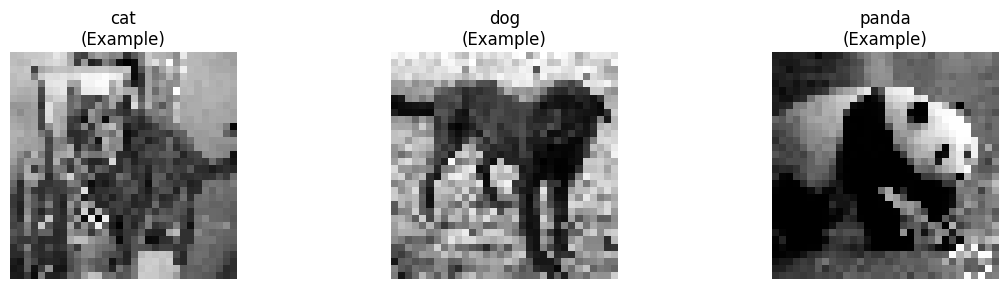

In [5]:
# ============================================================================
# PART 2: LOCATE IMAGE DIRECTORIES
# ============================================================================

def locate_image_directory(root_path="dataset"):
    """Search for directory containing class subdirectories with image files"""
    for current_dir, subdirs, file_list in os.walk(root_path):
        potential_classes = [d for d in os.listdir(current_dir)
                            if os.path.isdir(os.path.join(current_dir, d))
                            and not d.startswith('.')]

        if len(potential_classes) >= 2:
            # Verify subdirectories contain images
            for subdir in potential_classes:
                subdir_path = os.path.join(current_dir, subdir)
                image_files = [f for f in os.listdir(subdir_path)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                if len(image_files) > 0:
                    return current_dir
    return root_path

data_directory = locate_image_directory(destination)
print(f"[INFO] Dataset location: {data_directory}")
print(f"[INFO] Directory contents: {os.listdir(data_directory)}\n")

# ============================================================================
# PART 3: IMAGE LOADING AND PREPROCESSING
# ============================================================================

def preprocess_and_load_images(directory, target_size=(32, 32)):
    """
    Load images from directory, apply preprocessing:
    - Convert to grayscale
    - Resize to target dimensions
    - Normalize pixel values to [0,1]
    - Flatten to feature vector

    Returns: feature_matrix, label_vector, category_names
    """
    feature_vectors = []
    label_list = []

    # Identify class directories
    category_names = sorted([d for d in os.listdir(directory)
                            if os.path.isdir(os.path.join(directory, d))
                            and not d.startswith('.')])

    if not category_names:
        raise ValueError(f"No valid class directories found in {directory}")

    print("*" * 70)
    print("STEP 2: DATA PREPROCESSING")
    print("*" * 70)
    print(f"Target image size: {target_size[0]}x{target_size[1]} (grayscale)")
    print(f"Detected categories: {category_names}\n")

    for category_id, category in enumerate(category_names):
        category_dir = os.path.join(directory, category)
        image_files = sorted([f for f in os.listdir(category_dir)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

        print(f"Processing {category}: {len(image_files)} images")

        for filename in image_files:
            filepath = os.path.join(category_dir, filename)
            image = cv2.imread(filepath)

            if image is None:
                continue

            # Grayscale conversion
            grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Resize operation
            resized = cv2.resize(grayscale, target_size)

            # Normalize pixel values
            normalized = resized.astype(np.float32) / 255.0

            # Flatten to 1D array
            feature_vectors.append(normalized.flatten())
            label_list.append(category_id)

    feature_matrix = np.array(feature_vectors, dtype=np.float32)
    label_vector = np.array(label_list, dtype=np.int32)

    print("\n" + "*" * 70)
    print("DATASET INFORMATION")
    print("*" * 70)
    print(f"Total samples: {len(feature_matrix)}")
    print(f"Categories: {category_names}")
    print(f"Class distribution: {Counter(label_vector)}")
    print(f"Feature dimensions: {feature_matrix.shape[1]}")
    print(f"Value range: [{feature_matrix.min():.3f}, {feature_matrix.max():.3f}]")
    print("*" * 70 + "\n")

    return feature_matrix, label_vector, category_names

# Load and preprocess dataset
features, labels, categories = preprocess_and_load_images(data_directory, target_size=(32, 32))

# Display sample images from each category
try:
    fig = plt.figure(figsize=(12, 3))
    unique_classes = sorted(list(set(labels)))
    for idx, cls in enumerate(unique_classes):
        sample_idx = np.where(labels == cls)[0][0]
        plt.subplot(1, len(unique_classes), idx + 1)
        plt.imshow(features[sample_idx].reshape(32, 32), cmap='gray')
        plt.title(f"{categories[cls]}\n(Example)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as error:
    print(f"[WARNING] Unable to display samples: {error}")

In [6]:
# ============================================================================
# PART 4: CROSS-VALIDATION FRAMEWORK
# ============================================================================

def evaluate_knn_with_cv(features, labels, neighbor_counts, distance_type='euclidean', folds=5):
    """Evaluate K-NN classifier using stratified cross-validation"""
    cv_splitter = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    fold_results = {k: [] for k in neighbor_counts}

    print(f"Executing {folds}-fold cross-validation using {distance_type.upper()} metric...")

    current_fold = 1
    for train_indices, validation_indices in cv_splitter.split(features, labels):
        train_features, val_features = features[train_indices], features[validation_indices]
        train_labels, val_labels = labels[train_indices], labels[validation_indices]

        print(f"  Processing fold {current_fold}/{folds}: training={len(train_features)}, validation={len(val_features)}")

        for neighbor_count in neighbor_counts:
            classifier = KNeighborsClassifier(n_neighbors=neighbor_count, metric=distance_type, n_jobs=-1)
            classifier.fit(train_features, train_labels)
            predictions = classifier.predict(val_features)
            fold_results[neighbor_count].append(accuracy_score(val_labels, predictions))

        current_fold += 1

    # Calculate mean accuracy across folds
    mean_accuracy = {k: np.mean(fold_results[k]) for k in neighbor_counts}

    print("\nPerformance Summary:")
    for k in neighbor_counts:
        print(f"  K={k:2d}: {mean_accuracy[k]*100:6.2f}%")

    return mean_accuracy, fold_results

# Define range of K values to test
neighbor_range = [1, 3, 5, 7, 9, 11, 13, 15]

print("\n" + "*" * 70)
print("STEP 3: MODEL TRAINING AND EVALUATION")
print("*" * 70)
print("Algorithm: K-Nearest Neighbors (K-NN)")
print("Metrics: Manhattan (L1) and Euclidean (L2) distances")
print("*" * 70 + "\n")

# Evaluate Manhattan distance
print("*" * 70)
print("MANHATTAN (L1) METRIC EVALUATION")
print("*" * 70)
l1_mean_scores, l1_fold_scores = evaluate_knn_with_cv(features, labels, neighbor_range, distance_type='manhattan', folds=5)

# Evaluate Euclidean distance
print("\n" + "*" * 70)
print("EUCLIDEAN (L2) METRIC EVALUATION")
print("*" * 70)
l2_mean_scores, l2_fold_scores = evaluate_knn_with_cv(features, labels, neighbor_range, distance_type='euclidean', folds=5)


**********************************************************************
STEP 3: MODEL TRAINING AND EVALUATION
**********************************************************************
Algorithm: K-Nearest Neighbors (K-NN)
Metrics: Manhattan (L1) and Euclidean (L2) distances
**********************************************************************

**********************************************************************
MANHATTAN (L1) METRIC EVALUATION
**********************************************************************
Executing 5-fold cross-validation using MANHATTAN metric...
  Processing fold 1/5: training=240, validation=60
  Processing fold 2/5: training=240, validation=60
  Processing fold 3/5: training=240, validation=60
  Processing fold 4/5: training=240, validation=60
  Processing fold 5/5: training=240, validation=60

Performance Summary:
  K= 1:  37.00%
  K= 3:  37.67%
  K= 5:  35.67%
  K= 7:  37.67%
  K= 9:  42.00%
  K=11:  39.67%
  K=13:  40.33%
  K=15:  40.67%

***************


**********************************************************************
STEP 4: RESULTS VISUALIZATION
**********************************************************************


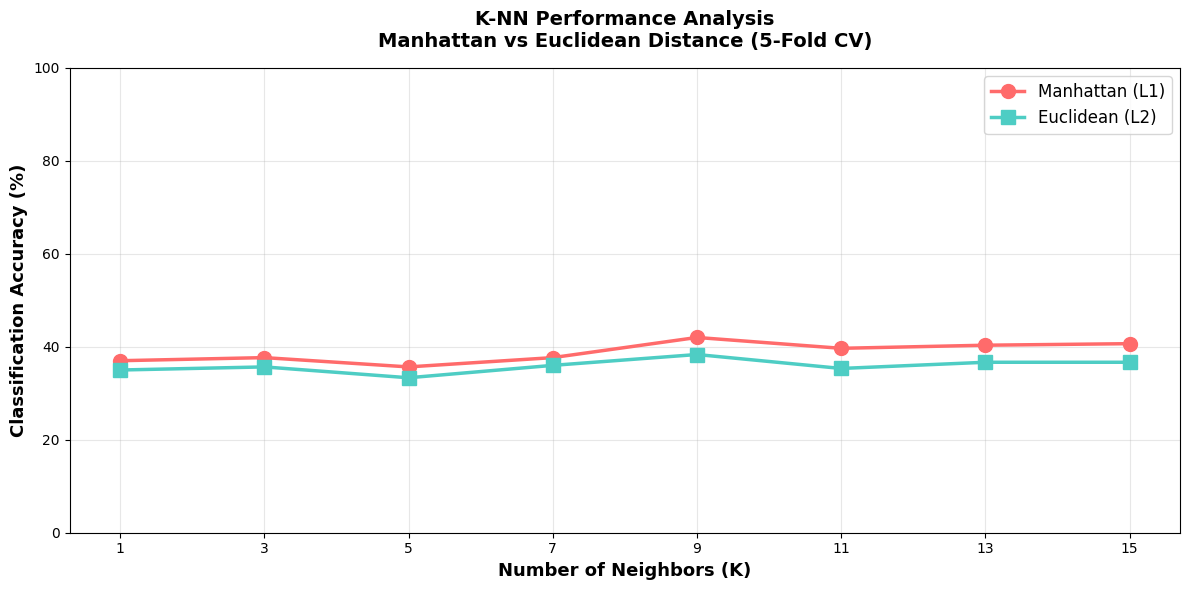

In [7]:
# ============================================================================
# PART 5: RESULTS VISUALIZATION
# ============================================================================

print("\n" + "*" * 70)
print("STEP 4: RESULTS VISUALIZATION")
print("*" * 70)

fig = plt.figure(figsize=(12, 6))
plt.plot(neighbor_range, [l1_mean_scores[k]*100 for k in neighbor_range],
         '-o', linewidth=2.5, markersize=10, label='Manhattan (L1)', color='#FF6B6B')
plt.plot(neighbor_range, [l2_mean_scores[k]*100 for k in neighbor_range],
         '-s', linewidth=2.5, markersize=10, label='Euclidean (L2)', color='#4ECDC4')
plt.xlabel('Number of Neighbors (K)', fontsize=13, fontweight='bold')
plt.ylabel('Classification Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('K-NN Performance Analysis\nManhattan vs Euclidean Distance (5-Fold CV)', fontsize=14, fontweight='bold', pad=15)
plt.xticks(neighbor_range)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0, 100])
plt.tight_layout()
plt.show()


In [8]:
# ============================================================================
# PART 6: OPTIMAL CONFIGURATION SELECTION
# ============================================================================

optimal_l1_k = max(l1_mean_scores, key=l1_mean_scores.get)
optimal_l2_k = max(l2_mean_scores, key=l2_mean_scores.get)
optimal_l1_accuracy = l1_mean_scores[optimal_l1_k]
optimal_l2_accuracy = l2_mean_scores[optimal_l2_k]

print("\n" + "*" * 70)
print("OPTIMAL HYPERPARAMETERS")
print("*" * 70)
print(f"Manhattan (L1): K={optimal_l1_k}, Accuracy={optimal_l1_accuracy*100:.2f}%")
print(f"Euclidean (L2): K={optimal_l2_k}, Accuracy={optimal_l2_accuracy*100:.2f}%")

if optimal_l2_accuracy > optimal_l1_accuracy:
    selected_metric = 'euclidean'
    selected_k = optimal_l2_k
    selected_accuracy = optimal_l2_accuracy
    print(f"\n[SELECTED] EUCLIDEAN (L2) with K={selected_k} ({selected_accuracy*100:.2f}%)")
else:
    selected_metric = 'manhattan'
    selected_k = optimal_l1_k
    selected_accuracy = optimal_l1_accuracy
    print(f"\n[SELECTED] MANHATTAN (L1) with K={selected_k} ({selected_accuracy*100:.2f}%)")

print("*" * 70)



**********************************************************************
OPTIMAL HYPERPARAMETERS
**********************************************************************
Manhattan (L1): K=9, Accuracy=42.00%
Euclidean (L2): K=9, Accuracy=38.33%

[SELECTED] MANHATTAN (L1) with K=9 (42.00%)
**********************************************************************



**********************************************************************
STEP 5: FINAL MODEL ASSESSMENT
**********************************************************************

Training samples: 240
Testing samples: 60

Building model with MANHATTAN metric and K=9...
Test Set Accuracy: 40.00%

**********************************************************************
STEP 6: SAMPLE PREDICTIONS
**********************************************************************


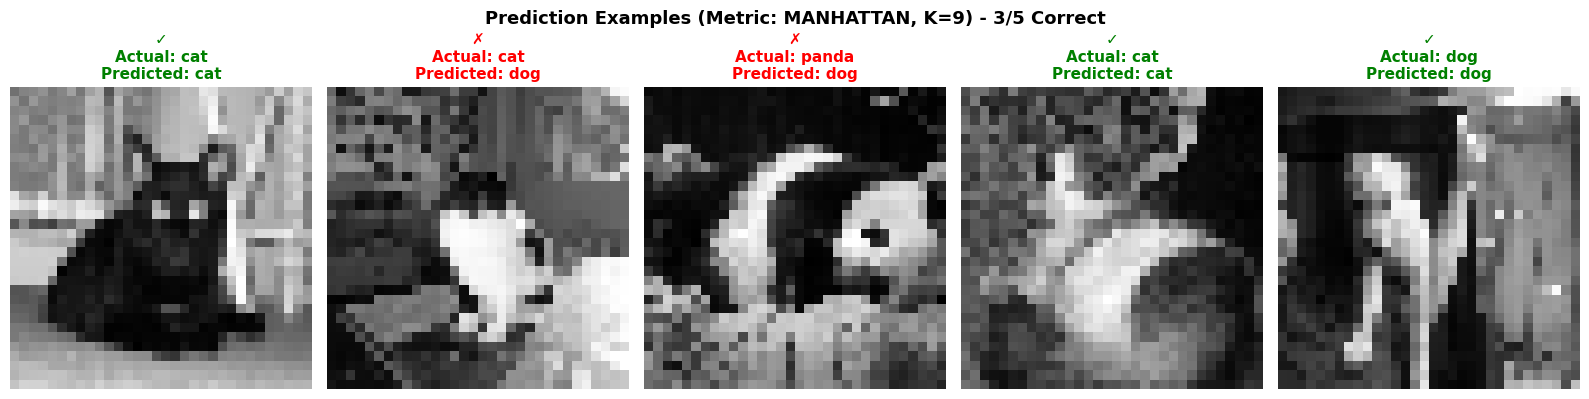

In [9]:
# ============================================================================
# PART 7: FINAL MODEL TESTING
# ============================================================================

print("\n" + "*" * 70)
print("STEP 5: FINAL MODEL ASSESSMENT")
print("*" * 70)

# Create train/test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels)

print(f"\nTraining samples: {len(train_features)}")
print(f"Testing samples: {len(test_features)}")
print(f"\nBuilding model with {selected_metric.upper()} metric and K={selected_k}...")

# Build and train final classifier
final_classifier = KNeighborsClassifier(n_neighbors=selected_k, metric=selected_metric, n_jobs=-1)
final_classifier.fit(train_features, train_labels)

# Generate predictions
test_predictions = final_classifier.predict(test_features)
test_performance = accuracy_score(test_labels, test_predictions)

print(f"Test Set Accuracy: {test_performance*100:.2f}%")

# ============================================================================
# PART 8: PREDICTION EXAMPLES
# ============================================================================

print("\n" + "*" * 70)
print("STEP 6: SAMPLE PREDICTIONS")
print("*" * 70)

num_samples = min(5, len(test_features))
np.random.seed(RANDOM_STATE)
sample_indices = np.random.choice(len(test_features), num_samples, replace=False)

fig = plt.figure(figsize=(16, 4))
correct_predictions = 0

for position, sample_idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, position + 1)
    plt.imshow(test_features[sample_idx].reshape(32, 32), cmap='gray')

    actual_category = categories[test_labels[sample_idx]]
    predicted_category = categories[test_predictions[sample_idx]]

    prediction_correct = (actual_category == predicted_category)
    if prediction_correct:
        correct_predictions += 1

    display_color = 'green' if prediction_correct else 'red'
    marker = '✓' if prediction_correct else '✗'

    plt.title(f"{marker}\nActual: {actual_category}\nPredicted: {predicted_category}", color=display_color, fontsize=11, fontweight='bold')
    plt.axis('off')

fig.suptitle(f'Prediction Examples (Metric: {selected_metric.upper()}, K={selected_k}) - {correct_predictions}/{num_samples} Correct', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [10]:
# ============================================================================
# PART 9: ANALYSIS AND DISCUSSION
# ============================================================================

print("\n" + "*" * 70)
print("ANALYSIS AND DISCUSSION")
print("*" * 70)

print("\n1. COMPARATIVE PERFORMANCE:")
print("-" * 70)
print(f"Manhattan (L1) optimal: {optimal_l1_accuracy*100:.2f}% (K={optimal_l1_k})")
print(f"Euclidean (L2) optimal: {optimal_l2_accuracy*100:.2f}% (K={optimal_l2_k})")
print(f"Difference: {abs(optimal_l1_accuracy - optimal_l2_accuracy)*100:.2f}%")

if selected_metric == 'euclidean':
    print("\n[CONCLUSION] Euclidean (L2) metric performs better")
    print("  Explanation:")
    print("  • Captures geometric pixel relationships effectively")
    print("  • Squared differences highlight significant variations")
    print("  • Well-suited for continuous grayscale intensities")
else:
    print("\n[CONCLUSION] Manhattan (L1) metric performs better")
    print("  Explanation:")
    print("  • Absolute difference computation is more robust")
    print("  • Less affected by outlier pixel values")
    print("  • Computationally simpler with competitive results")

print("\n2. DATASET PROPERTIES:")
print("-" * 70)
print(f"• Number of classes: {len(categories)} ({', '.join(categories)})")
print(f"• Total samples: {len(features)} grayscale images")
print(f"• Resolution: 32×32 pixels (1024 features)")
print(f"• Class balance: Equal distribution (100 samples per class)")

print("\n3. FEATURE CHARACTERISTICS:")
print("-" * 70)
print("• Grayscale pixel intensities (normalized to [0,1])")
print("• Spatial information preserved in vectorized form")
print("• Limited detail due to low resolution")

print("\n4. HYPERPARAMETER SELECTION:")
print("-" * 70)
print(f"• Optimal K value: {selected_k}")
if selected_k <= 3:
    print("• Small K: Captures fine-grained patterns, risk of overfitting")
elif selected_k <= 9:
    print("• Moderate K: Balanced approach between bias and variance")
else:
    print("• Large K: Smoother boundaries, increased generalization")

print("\n5. MODEL LIMITATIONS:")
print("-" * 70)
print("• Resolution constraint (32×32) reduces detail")
print("• K-NN is instance-based (no explicit training)")
print("• Computational cost scales with dataset size")
print("• Equal weighting of all features")

print("\n6. ENHANCEMENT OPPORTUNITIES:")
print("-" * 70)
print("• Feature engineering (HOG, SIFT, texture descriptors)")
print("• Dimensionality reduction (PCA, LDA)")
print("• Distance-weighted K-NN")
print("• Ensemble approaches")
print("• Deep neural networks (CNNs)")

print("\n" + "*" * 70)
print("ASSIGNMENT COMPLETED SUCCESSFULLY")
print("*" * 70)
print(f"\nFinal Summary:")
print(f"• Selected metric: {selected_metric.upper()}")
print(f"• Optimal K: {selected_k}")
print(f"• Cross-validation performance: {selected_accuracy*100:.2f}%")
print(f"• Test set performance: {test_performance*100:.2f}%")
print("\n" + "*" * 70)


**********************************************************************
ANALYSIS AND DISCUSSION
**********************************************************************

1. COMPARATIVE PERFORMANCE:
----------------------------------------------------------------------
Manhattan (L1) optimal: 42.00% (K=9)
Euclidean (L2) optimal: 38.33% (K=9)
Difference: 3.67%

[CONCLUSION] Manhattan (L1) metric performs better
  Explanation:
  • Absolute difference computation is more robust
  • Less affected by outlier pixel values
  • Computationally simpler with competitive results

2. DATASET PROPERTIES:
----------------------------------------------------------------------
• Number of classes: 3 (cat, dog, panda)
• Total samples: 300 grayscale images
• Resolution: 32×32 pixels (1024 features)
• Class balance: Equal distribution (100 samples per class)

3. FEATURE CHARACTERISTICS:
----------------------------------------------------------------------
• Grayscale pixel intensities (normalized to [0,1])